In [1]:
import pandas as pd
import numpy as np
import os
import gget
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sys
import itertools
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import scipy

sys.path.append("../")
import utils as ut

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
]

print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = lf.drop_duplicates(subset='cellId')
    lf = lf[lf['cellType'].isin(macTypes)]
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    

    cellIds = lf['cellId'].to_list()
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']

    rf = rf[rf.index.isin(cellIds)]
    print(f"{key=} {lf.shape=} {rf.shape}")
    
    rf = ut.normalize(rf, 1e6)
    rna[key] = rf
    

print('done')


ND...
key='ND' lf.shape=(536, 6) (534, 31053)
HFD8...
key='HFD8' lf.shape=(2909, 6) (2902, 31053)
HFD14...
key='HFD14' lf.shape=(4903, 6) (4893, 31053)
done


In [3]:
for key in keys:
    ldf = labels[key]
    print(ldf.head())

               cellId   cellType sampleInfo         x         y   colors
0  AAAGAACGTCTACAGT.1       Mac1         ND  3.089298 -1.726030  #fdbf6f
1  AAAGAACTCCTCGCAT.1       Mac1         ND  3.614130 -1.571004  #fdbf6f
2  AAAGGGCGTTAGGGTG.1       Mac3         ND  3.086352  6.166065  #fdbf6f
3  AACAAAGAGTATAGGT.1  Monocytes         ND  3.178745  4.929769  #ffffbe
4  AACAAAGCACCGGCTA.1       Mac3         ND  4.344001  5.801922  #fdbf6f
               cellId   cellType sampleInfo         x         y   colors
0  AAACCCACACAAAGCG.1       Mac4       HFD8 -0.985782  2.308999  #fdbf6f
1  AAACGCTTCGGACCAC.1       Mac2       HFD8  4.749476  0.898241  #fdbf6f
2  AAACGCTTCTGCAGCG.1  Monocytes       HFD8  2.145450  3.994834  #ffffbe
3  AAAGAACCAAAGCGTG.1       Mac5       HFD8 -4.052603  0.994102  #fdbf6f
4  AAAGAACCAACACGAG.1       Mac4       HFD8 -1.026867  2.441957  #fdbf6f
               cellId   cellType sampleInfo         x         y   colors
0  AAACCCAAGACTTCAC.1       Mac5      HFD14 -0.5877

In [4]:
# merge all expression
rdf = []
for key in keys:
    rf = rna[key].copy()
    rf.index = rf.index + "_" + key
    rdf.append(rf)

rdf = pd.concat(rdf)
print(f"{rdf.shape=}")
rdf.head()

rdf.shape=(8329, 31053)


Unnamed: 0,XKR4,GM1992,GM37381,RP1,SOX17,GM37323,MRPL15,LYPLA1,GM37988,TCEA1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,VMN2R122,CAAA01147332.1
cellId,,,,,,,,,,,,,,,,,,,,,
AAAGAACGTCTACAGT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365.89828,...,0.0,0.0,0.0,0.0,0.0,0.0,365.89828,365.89828,0.0,0.0
AAAGAACTCCTCGCAT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1103.509159,220.701832,0.0,0.0
AAAGGGCGTTAGGGTG.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,111.994624,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.994624
AACAAAGAGTATAGGT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,99.532199,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.532199,0.0,0.0
AACAAAGCACCGGCTA.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,85.697146,0.0,0.0,0.0


In [5]:
""" Build the reference dataframe """
ref = []
for key in keys:
    lf = labels[key]
    ref.append(lf)

ref = pd.concat(ref, ignore_index=True)
ref = ref.rename(columns={'sampleInfo' : 'key'})
ref['id'] = ref['cellId'] + "_" + ref['key']
print(f"{ref.shape=}")
ref.head()

ref.shape=(8348, 7)


,cellId,cellType,key,x,y,colors,id
0,AAAGAACGTCTACAGT.1,Mac1,ND,3.089298,-1.726030,#fdbf6f,AAAGAACGTCTACAGT.1_ND
1,AAAGAACTCCTCGCAT.1,Mac1,ND,3.614130,-1.571004,#fdbf6f,AAAGAACTCCTCGCAT.1_ND
2,AAAGGGCGTTAGGGTG.1,Mac3,ND,3.086352,6.166065,#fdbf6f,AAAGGGCGTTAGGGTG.1_ND
3,AACAAAGAGTATAGGT.1,Monocytes,ND,3.178745,4.929769,#ffffbe,AACAAAGAGTATAGGT.1_ND
4,AACAAAGCACCGGCTA.1,Mac3,ND,4.344001,5.801922,#fdbf6f,AACAAAGCACCGGCTA.1_ND


# Jaitin-Style Plots

len(cid1)=1901 len(cid3)=2215 len(cid3)=2215
pdf.shape=(6160, 8)
LGALS3 gVec.max()=32948.93 gVec.mean()=5770.51 np.median(gVec)=4332.76
TREM2 gVec.max()=6085.19 gVec.mean()=1177.22 np.median(gVec)=1023.24
GPNMB gVec.max()=22551.09 gVec.mean()=1121.49 np.median(gVec)=233.62
MS4A7 gVec.max()=5042.02 gVec.mean()=425.69 np.median(gVec)=189.43
CTSL gVec.max()=38659.88 gVec.mean()=1793.54 np.median(gVec)=768.61
MMP12 gVec.max()=42173.11 gVec.mean()=898.12 np.median(gVec)=0.00


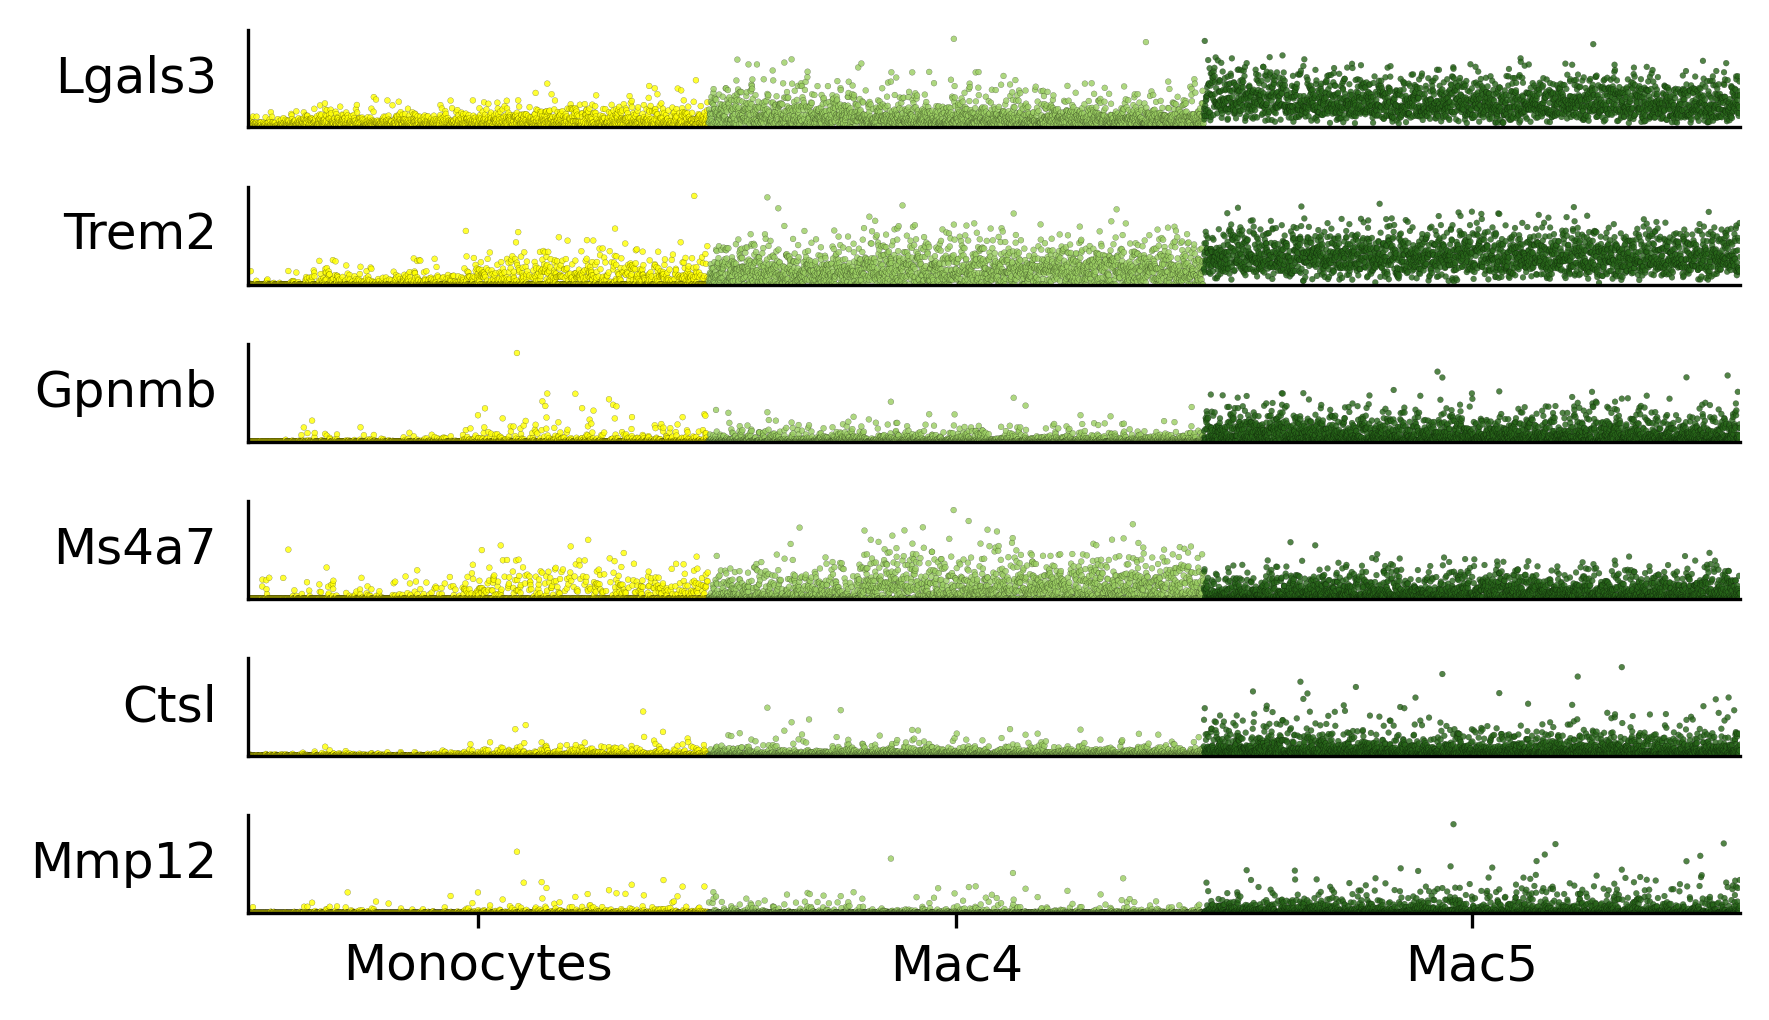

In [6]:
# get cell ids
cid1 = ref[ref['cellType'] == 'Monocytes']['id'].to_list()
cid2 = ref[ref['cellType'] == 'Mac4']['id'].to_list()
cid3 = ref[ref['cellType'] == 'Mac5']['id'].to_list()
cids = cid1 + cid2 + cid3

n1 = len(cid1)
n2 = len(cid2)
n3 = len(cid3)


# type variables
c1 = ['yellow'] * n1
# c1 = ['orange'] * n1
c2 = ['#9acd61'] * n2
c3 = ['#276419'] * n3
colors = c1 + c2 + c3

xticks = [ (n1 // 2), (n1 + (n2 // 2)), (n1 + n2 + (n3//2)) ] 
xticklabels = ["Monocytes", "Mac4", "Mac5"]

# print(cid1[0])
# print(cid2[0])
# print(cids.index(cid2[0]))

print(f"{len(cid1)=} {len(cid3)=} {len(cid3)=}")

# genes = [
#     'CCR2',
#     'Axl',
#     'cx3cr1',
#     "nr4a1",
#     'Ly6c2',
#     "Ms4a4c",
# ]

genes = [
    "Lgals3", 
    "trem2",
    "gpnmb",
    "MS4A7",
    "ctsl",
    "mmp12",
]



genes = [x.upper() for x in genes]

pdf = rdf[rdf.index.isin(cids)]
pdf = pdf.reindex(cids) # sort the rna by the cell ids
pdf = pdf[genes]
pdf = pdf.fillna(0)
pdf['num'] = np.arange(len(pdf))
pdf['color'] = colors
print(f"{pdf.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3.5
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(len(genes), 1)
axs = axs.ravel()

fontsize = 12

for i, g in enumerate(genes):
    
    # gVec = np.log1p(pdf[g].astype(float).to_numpy())
    gVec = pdf[g].astype(float).to_numpy()
    print(f"{g} {gVec.max()=:.2f} {gVec.mean()=:.2f} {np.median(gVec)=:.2f}")
    gVec = sklearn.preprocessing.minmax_scale(gVec, feature_range=(0, 1))
    
    
#     axs[i].bar(pdf['num'], 
#                gVec, 
#                color=pdf['color'])
    
    axs[i].scatter(pdf['num'], 
           gVec, 
           s=2,
           color=pdf['color'],
           ec='k',
           lw=0.05,        
           alpha=0.8,
          )
    
    # axis formatting
    axs[i].set_xticks([])
    axs[i].set_ylabel(f"{g.lower().capitalize()}", 
                      rotation=0,
                      fontsize=fontsize,
                      verticalalignment='center',
                      horizontalalignment='right')
    axs[i].set_xlabel("")
    axs[i].set_xlim([0, pdf['num'].max()])
    axs[i].set_ylim([0, 1.1])
    # axs[i].set_yticks([0, gVec.max()], [0, f"{gVec.max():.1f}"])
    axs[i].set_yticks([])
    axs[i].set_facecolor('None')
    
plt.xticks(xticks, xticklabels, fontsize=fontsize)

    
sns.despine()
plt.tight_layout()

In [7]:
# outdir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/FIG3/"
# name = "jaitinStyleMacrophage.csv"
# pdf.to_csv(f"{outdir}{name}", index=False,)
# print('done')

In [8]:
# break

(0.0, 1.0, 0.0, 1.0)

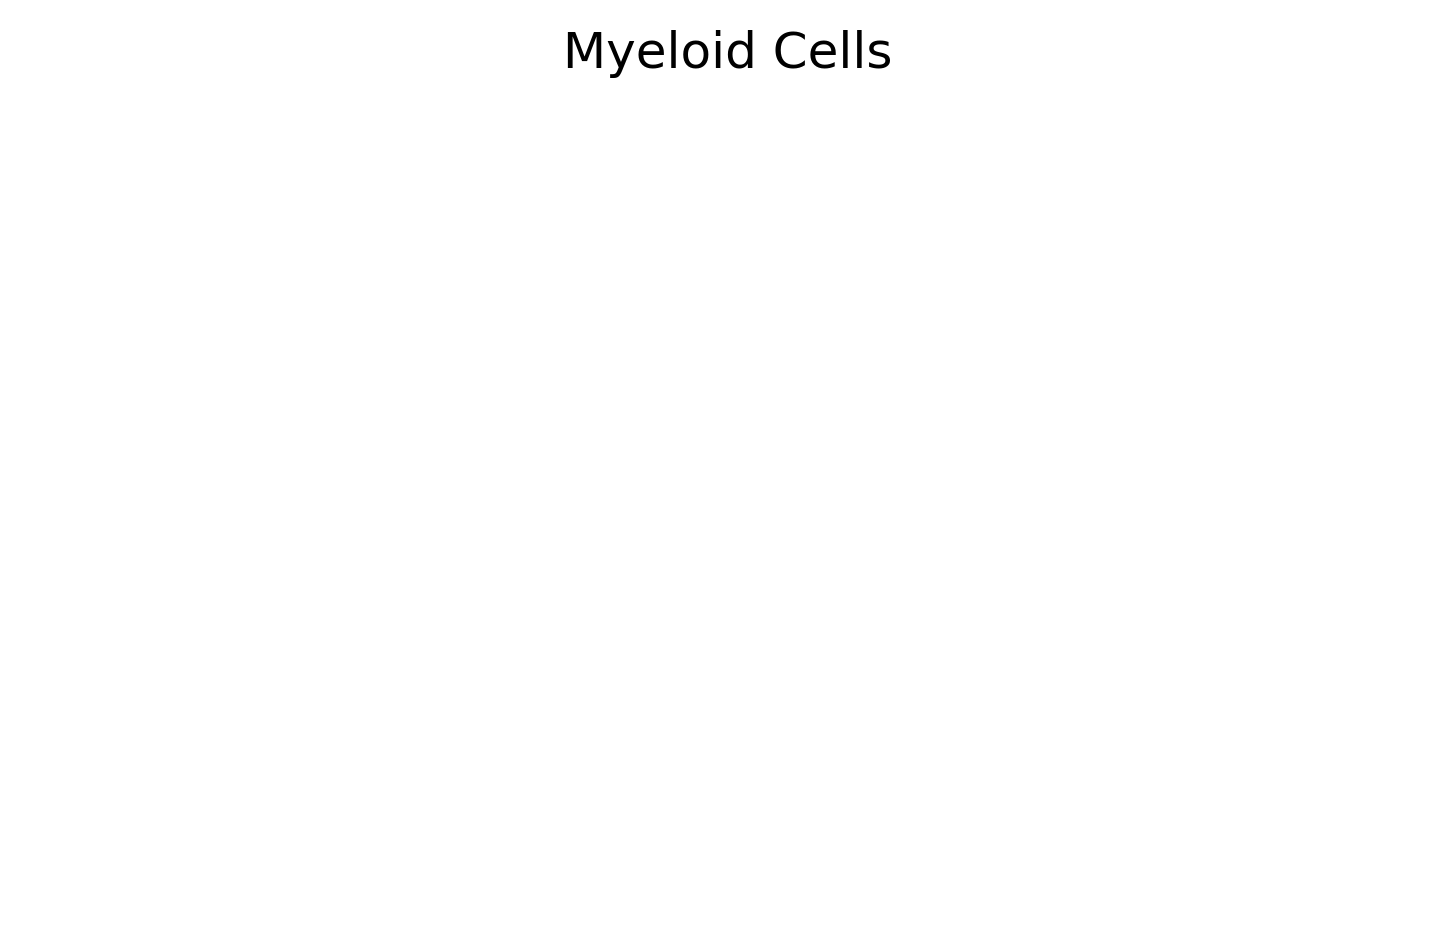

In [9]:

plt.rcParams['figure.facecolor'] = 'None'
fig, axs = plt.subplots()
axs.set_title("Myeloid Cells")
axs.set_facecolor("None")
axs.axis(False)

In [10]:
# break

# Variable genes

In [12]:
t = 0.0001
var = rdf.std(axis=0)
print(f"{var.shape=}")
# print(var[np.isfinite(var)].describe())

genes = var[var > t]
print(f"{genes.shape=}")

var.shape=(31053,)
genes.shape=(18052,)


In [13]:
# get differential expression of the markers
deg = []

for mtype in sorted(ref['cellType'].unique()):
    print(f"working {mtype}...")
    cellIds = ref[ref['cellType'] == mtype]['id'].to_list()
    
    mask = rdf.index.isin(cellIds)
    inGroup = rdf[mask]
    outGroup = rdf[~mask]

    """DEG for highly variable genes"""
    for g in genes.index:
        score, pval = scipy.stats.ranksums(inGroup[g], outGroup[g],
                                           alternative='two-sided')

        lfc = np.log2(inGroup[g].mean()+1) - np.log2(outGroup[g].mean()+1)

        row = {
            'gene' : g,
            "cellType" : mtype,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc,
            'meanP1' : inGroup[g].mean(),
            'propP1' : inGroup[g].astype(bool).sum() / len(inGroup),
            'meanP2' : outGroup[g].mean(),
            'propP2' : outGroup[g].astype(bool).sum() / len(outGroup),
        }
        deg.append(row)
    
deg = pd.DataFrame(deg)
deg.head()

working Mac1...
working Mac2...
working Mac3...
working Mac4...
working Mac5...
working Monocytes...


,gene,cellType,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2
0,SOX17,Mac1,-0.013724,0.989051,-0.067463,0.000000,0.000000,0.047872,0.000272
1,MRPL15,Mac1,-4.117803,0.000038,-0.235853,47.919021,0.233645,56.607192,0.333695
2,LYPLA1,Mac1,-1.248042,0.212016,0.073555,32.684760,0.161994,31.010400,0.198344
3,GM37988,Mac1,-0.027447,0.978103,-0.067064,0.000000,0.000000,0.047583,0.000543
4,TCEA1,Mac1,-4.047354,0.000052,-0.284874,54.993202,0.249221,67.216751,0.349715


alpha=0.05 ntests=18052.0 2.841414885601523e-06
mtype='Mac1' mdf.shape[0]=521 (total DEGs) 
mtype='Mac2' mdf.shape[0]=299 (total DEGs) 
mtype='Mac3' mdf.shape[0]=876 (total DEGs) 
mtype='Mac4' mdf.shape[0]=335 (total DEGs) 
mtype='Mac5' mdf.shape[0]=1975 (total DEGs) 
mtype='Monocytes' mdf.shape[0]=284 (total DEGs) 


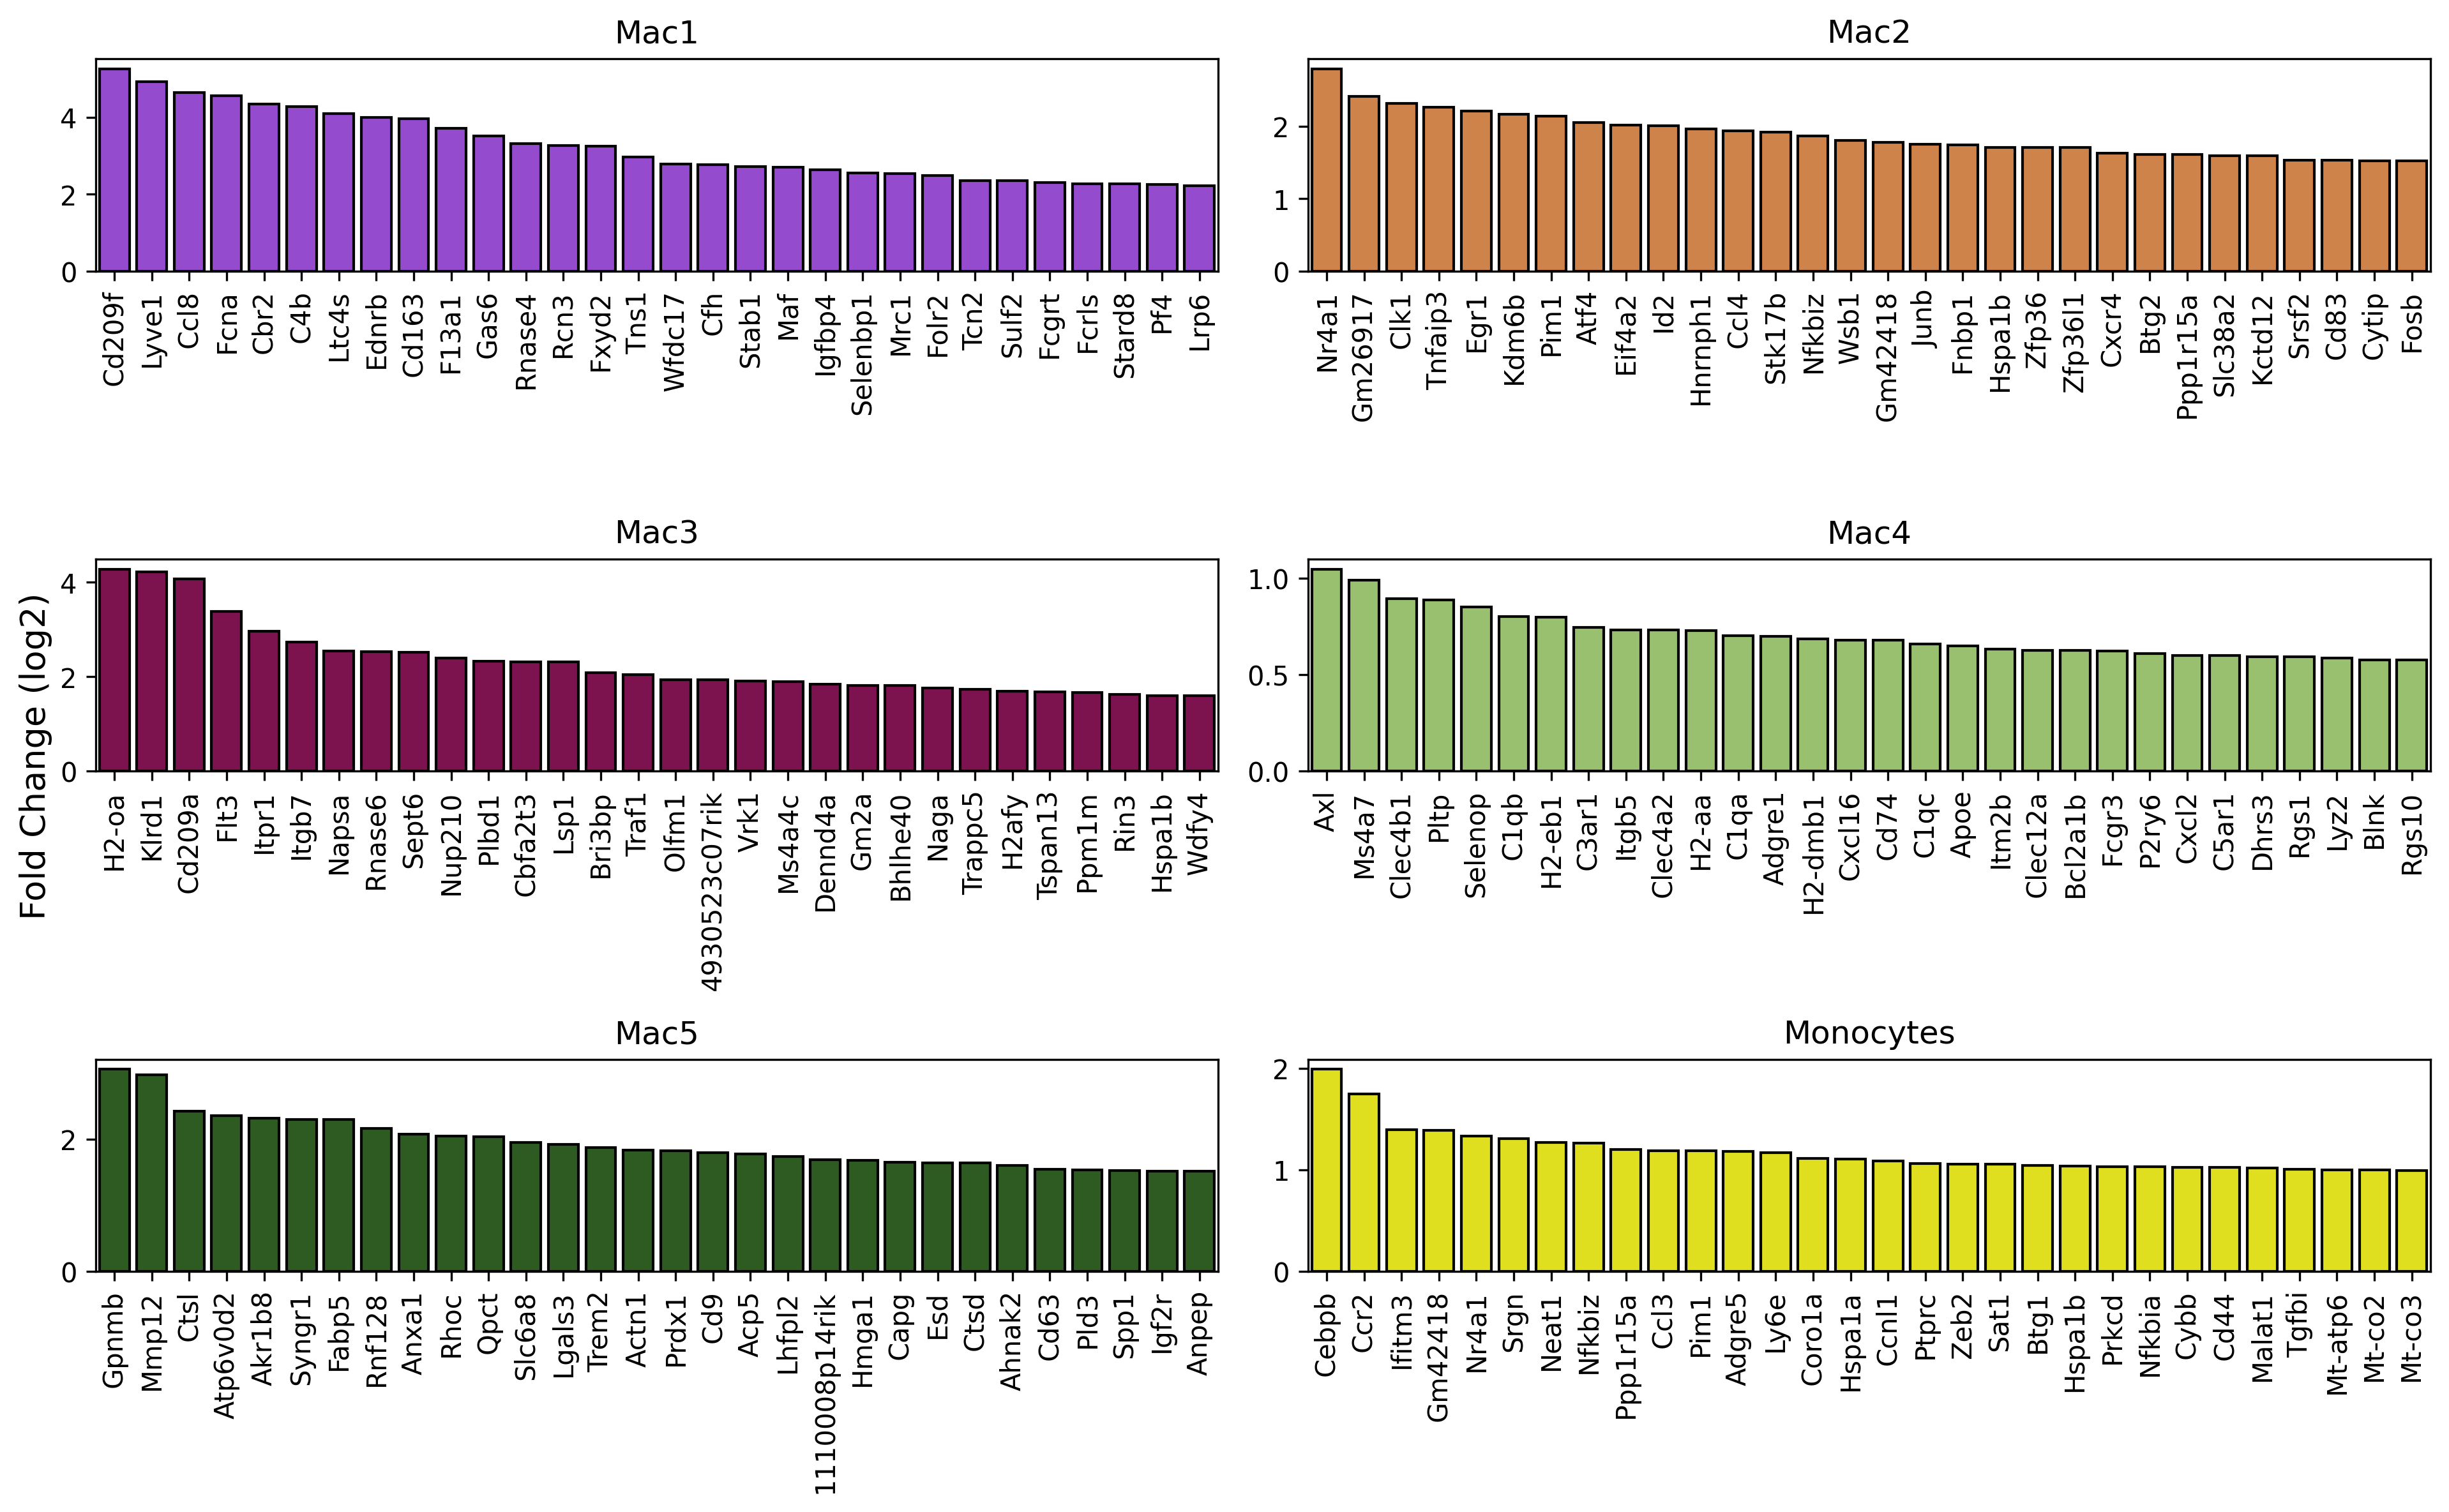

In [14]:
alpha = 0.05
plotN = 15
prop = 0.5
ntests = len(deg) / len(macTypes)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 13, 8
plt.rcParams['figure.facecolor'] = "w"


colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    'yellow',
]


fig, axs = plt.subplots(3, 2)
axs = axs.ravel()


for i, mtype in enumerate(deg['cellType'].unique()):
    
    # get significant DEGs
    mdf = deg[deg['cellType'] == mtype]
    mdf = mdf[mdf['pval'] < alphaHat]
    mdf = mdf[mdf['propP1'] > prop]
    print(f"{mtype=} {mdf.shape[0]=} (total DEGs) ")
    
    mdf = mdf.sort_values(by='log2foldchange', ascending=False)
    mdf = mdf.head(plotN*2)
    # mdf = pd.concat([mdf.head(plotN), mdf.tail(plotN)])
    
    mdf['geneName'] = mdf['gene'].apply(lambda x: str(x).lower().capitalize())
    
    sns.barplot(data=mdf, 
                y='log2foldchange',
                x='geneName',
                edgecolor='k',
                color=colors[i],
                ax=axs[i])
    
    # axs[i].set_title(mtype)
    # axs[i].set_ylabel(mtype, rotation=0, labelpad=10, horizontalalignment='left')
    axs[i].set_title(mtype)
    # axs[i].yaxis.set_label_position("right")
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    
fig.supylabel("Fold Change (log2)", fontsize=13)
plt.tight_layout()
    
    

In [16]:
outdir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/SUPP/"
fname = "macrophage_DEGs.csv"

deg.to_csv(f"{outdir}{fname}", index=False)
deg.head()

,gene,cellType,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2
0,SOX17,Mac1,-0.013724,0.989051,-0.067463,0.000000,0.000000,0.047872,0.000272
1,MRPL15,Mac1,-4.117803,0.000038,-0.235853,47.919021,0.233645,56.607192,0.333695
2,LYPLA1,Mac1,-1.248042,0.212016,0.073555,32.684760,0.161994,31.010400,0.198344
3,GM37988,Mac1,-0.027447,0.978103,-0.067064,0.000000,0.000000,0.047583,0.000543
4,TCEA1,Mac1,-4.047354,0.000052,-0.284874,54.993202,0.249221,67.216751,0.349715


In [ ]:
break

# Correlations

In [ ]:
alpha = 0.01
plotN = 15
prop = 0.25
lft = 1
ntests = len(deg) / len(macTypes)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
ENRICHALPHA = 0.05
top = 10
# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'

sig = deg.copy()
sig = sig[sig['pval'] < alphaHat]
sig = sig[sig['propP1'] > prop]
sig = sig[sig['log2foldchange'].abs() >= lft]

genes = sig['gene'].unique()
print(f"{len(genes)=}")

for ct in sig['cellType'].unique():
    print()
    print(f"===== {ct} =====")
    
    cx = sig[sig['cellType'] == ct]
    ctGenes = cx['gene'].unique()
    
    ef = gget.enrichr(ctGenes, database=db)
    ef = ef[ef['adj_p_val'] <= ENRICHALPHA]
    pd.set_option('display.max_colwidth', 200)
    print(ef[['path_name', 'overlapping_genes']].head(top))
    



In [ ]:
break

# Pairwise Compairisons

In [ ]:
# gets genes expressed in 10% of the population
t = 0.1
nExp = rdf.astype(bool).sum(axis=0)
print(f"{nExp.shape=}")
nExp = nExp / rdf.shape[0]

genes = nExp[nExp > t]
print(f"{genes.shape=}")

In [ ]:
genes.head()

In [ ]:
macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
]


deg = []

for i_ct, j_ct in itertools.combinations(macTypes, 2):
    print(i_ct, j_ct)
    
    i_cids = ref[ref['cellType'] == i_ct]['id'].to_list()
    j_cids = ref[ref['cellType'] == j_ct]['id'].to_list()
    
    inGroup = rdf[rdf.index.isin(i_cids)]
    outGroup = rdf[rdf.index.isin(j_cids)]

    for g in genes.index:
            score, pval = scipy.stats.ranksums(inGroup[g], outGroup[g],
                                               alternative='two-sided')

            lfc = np.log2(inGroup[g].mean()+1) - np.log2(outGroup[g].mean()+1)

            row = {
                'gene' : g,
                "i_ct" : i_ct,
                "j_ct" : j_ct,
                'score' : score,
                'pval' : pval,
                'log2foldchange' : lfc,
                'meanP1' : inGroup[g].mean(),
                'propP1' : inGroup[g].astype(bool).sum() / len(inGroup),
                'meanP2' : outGroup[g].mean(),
                'propP2' : outGroup[g].astype(bool).sum() / len(outGroup),
            }
            deg.append(row)

deg = pd.DataFrame(deg)
deg.head()

In [ ]:
alpha = 0.01
ntests = len(genes)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

sig = deg[deg['log2foldchange'].abs() > 1]
sig = sig[sig['pval'] < alphaHat]
print(sig.shape)

sig['up'] = np.where(sig['log2foldchange'] > 0, 1, 0)
sig['down'] = np.where(sig['log2foldchange'] <= 0, 1, 0)


gx = sig.groupby(['i_ct', 'j_ct']).agg(
 up = ('up', 'sum'),
 down = ('down', 'sum'),
).reset_index(drop=False)

print(gx.to_latex(index=False))

In [ ]:
sig.head()

In [ ]:
sig.to_csv("~/temp/pairwiseDEG.csv", index=False)